## Logistic Regression and Feedforward Neural Network (FFNN) Models

### Import standard libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# For hyperparameter tuning
import keras_tuner
from tensorflow import keras

# Unused atm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

### Import data

In [2]:
# Load data that was output from the preprocessing notebook
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
Y_train = pd.read_csv('data/Y_train.csv', index_col=0)
Y_test = pd.read_csv('data/Y_test.csv', index_col=0)

# Check data shapes
display(X_train.shape)
display(X_test.shape)
display(Y_train.shape)
display(Y_test.shape)

# Check the first few rows
display(X_train.head())

(493, 24)

(124, 24)

(493, 1)

(124, 1)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.690887,0.685788,1.006226,-1.171854,0.136816,0.093421,-0.481733,0.392191,-0.176123,-0.091700,...,0.838373,-1.056261,0.535441,1.200978,-0.158611,-0.077590,-0.139836,-0.224102,-0.726805,-0.018811
1,-0.441772,0.454223,1.462607,-0.617965,-0.293618,0.023432,0.153689,-1.660740,-0.165092,0.878005,...,0.786217,-1.216243,0.658438,0.838084,0.360564,-0.085385,-0.239045,-0.435239,-0.537305,-0.387489
2,0.671402,-1.941961,-1.723888,0.351624,0.629489,1.202796,1.880502,1.530765,-0.002930,0.937556,...,1.091466,0.823074,-0.526456,-0.124357,-0.583080,-0.040892,0.021261,1.472451,-0.945578,0.924031
3,-1.129595,-1.193760,1.500116,-0.829614,0.123395,0.421081,1.446770,-1.168590,0.334539,0.943517,...,1.113140,-0.061908,-0.002122,-0.511413,0.160301,0.051340,-1.812252,0.043625,0.140780,-0.521942
4,-0.449661,0.533336,-2.227092,1.630291,-0.744035,-0.592698,0.645509,-0.155894,-1.008784,0.356228,...,-0.789424,0.171670,0.285349,0.590511,-0.380552,-0.343775,-0.816738,-0.552360,-0.553257,-0.493903


### Modeling

Build the Model

In [3]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate=0.1):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Create hidden layers with dropout layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
        
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss for binary classification problem
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

In [4]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       dropout_rate=0.1,
                       num_epochs=5,
                       num_folds=10):

  # Address the class imbalances by using class weights.
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
  weight_for_0 = (1 / Y_train.value_counts()[0]) * (Y_train.size / 2.0)
  weight_for_1 = (1 / Y_train.value_counts()[1]) * (Y_train.size / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}
    
  # Create a k-fold object with k subsets
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

  # Create a list to hold the accuracy for each k-fold.
  accuracy_history = []
    
  # Iterate over the k subsets
  for train_index, test_index in kfold.split(X_train):
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_k, Y_test_k = Y_train.iloc[train_index], Y_train.iloc[test_index]
 
        # Build the model.
        model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                      dropout_rate=dropout_rate)

        # Train the model.
        print('Training...')
        history = model.fit(
            x=X_train_k,                # our binary training examples
            y=Y_train_k,                # corresponding binary labels
            epochs=num_epochs,        # number of passes through the training data
            batch_size=32,            # mini-batch size for SGD
            validation_split=0.2,     # use a fraction of the examples for validation
            verbose=0,                # do not display progress output during training
            class_weight=class_weight # use the calculated class weights to address the imbalance
            )
        
        # Calculate the accuracy of the model
        test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']

        print(f'Accuracy: {test_accuracy}')
        
        # Add the accuracy to the history list
        accuracy_history.append(test_accuracy)
        
        # Plot the loss and accuracy
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        ax1, ax2 = axes.ravel()

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax1.plot(train_loss, label='train_loss')
        ax1.plot(val_loss, label='validation loss')
        ax1.set_xticks(range(num_epochs))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')        
        ax1.set_xticks(np.arange(0, num_epochs+1, num_epochs/10))
        ax1.legend()

        train_accuracy = history.history['binary_accuracy']
        val_accuracy = history.history['val_binary_accuracy']
        ax2.plot(train_accuracy, label='train_accuracy')
        ax2.plot(val_accuracy, label='validation accuracy')
        ax2.set_xticks(range(num_epochs))
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_xticks(np.arange(0, num_epochs+1, num_epochs/10))
        ax2.legend()

        plt.show()

        # Plot the confusion matrix
        Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
        confusion_matrix = tf.math.confusion_matrix(Y_test['class'].to_numpy(), Y_pred)        

        sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        
  # Print the model summary.
  print(model.summary())
    
  # Print the average accuracy of the k folds.
  print(f'Average Accuracy: {sum(accuracy_history) / len(accuracy_history)}')


### Logistic Regression Model

Training...
Accuracy: 0.8467742204666138


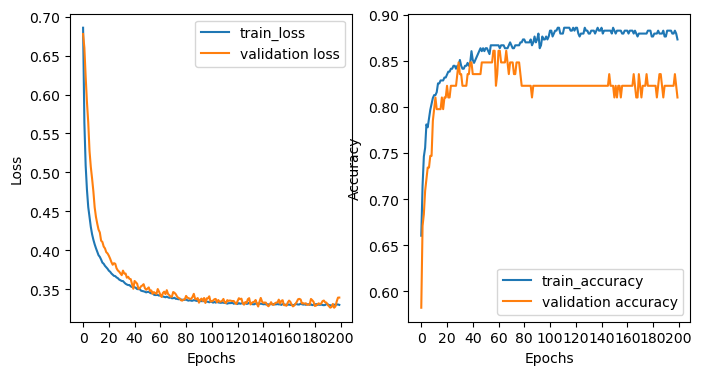

4/4 [==============================] - 0s 667us/step


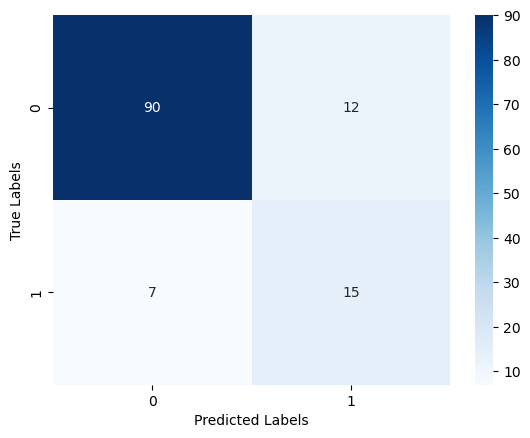

Training...
Accuracy: 0.8145161271095276


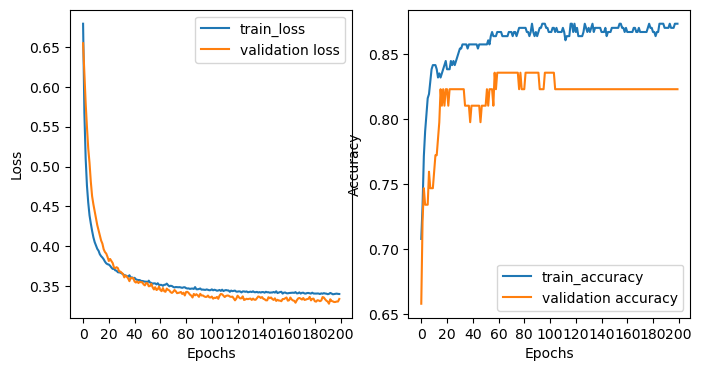

4/4 [==============================] - 0s 668us/step


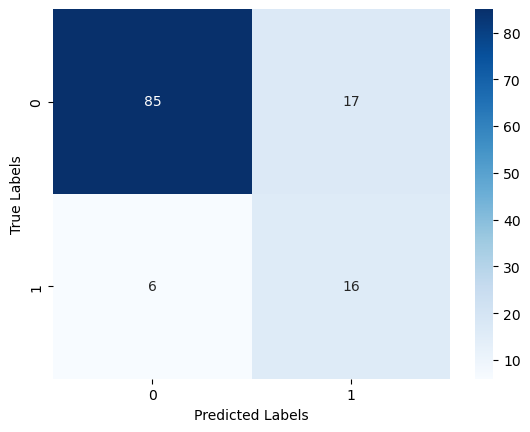

Training...
Accuracy: 0.8548387289047241


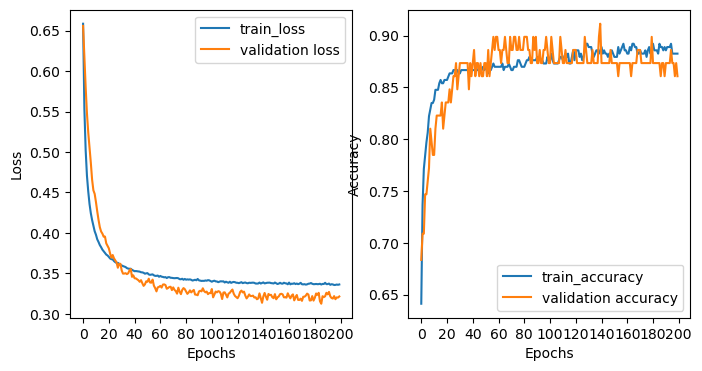

4/4 [==============================] - 0s 758us/step


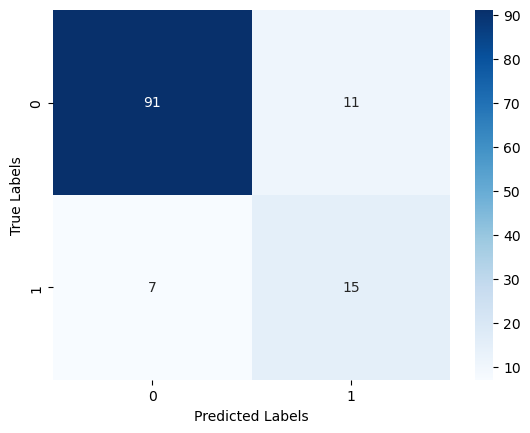

Training...
Accuracy: 0.8548387289047241


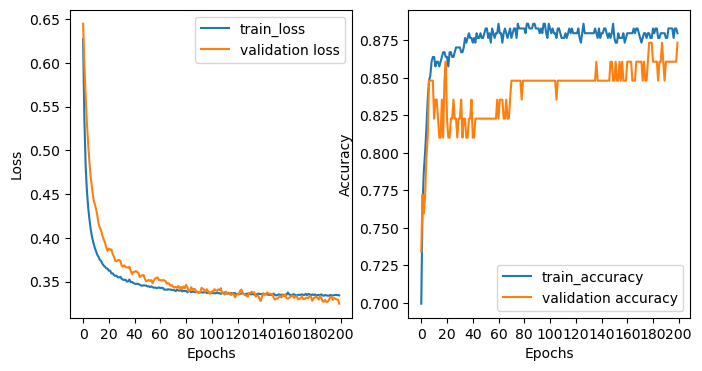

4/4 [==============================] - 0s 1ms/step


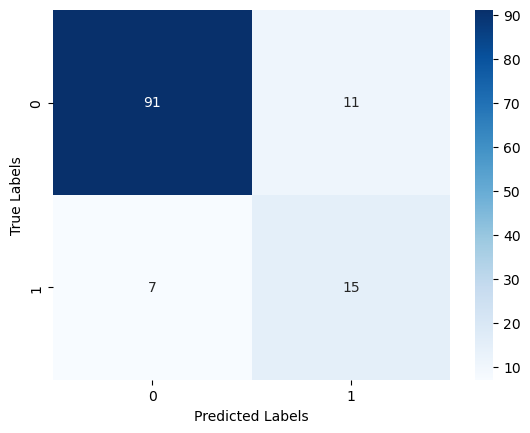

Training...
Accuracy: 0.8225806355476379


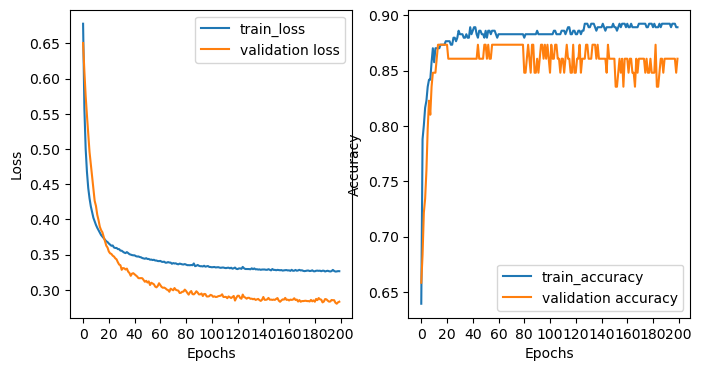

4/4 [==============================] - 0s 0s/step


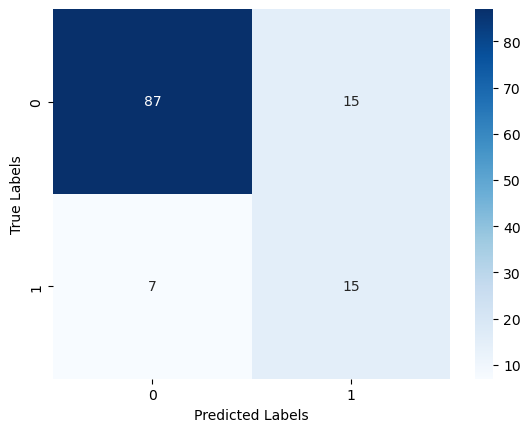

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8387096881866455


In [5]:
# When implemented in TensorFlow, the logistic regression model only has
# an input layer and an output layer. There are no hidden layers.

train_and_evaluate(
    hidden_layer_sizes=[],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    dropout_rate=0.0,
    num_epochs=200,
    num_folds=5)

In [6]:
# The learning curves for the logistic regression model above generally look good based on the 
# elbow shape to the learning curves. However, the validation loss is lower than the training loss
# in several of the folds, so this may indicate some underfitting. The solution to this issue
# is to increase model complexity (e.g. move to a FFNN).

### Feedforward Neural Network Model

Training...
Accuracy: 0.8629032373428345


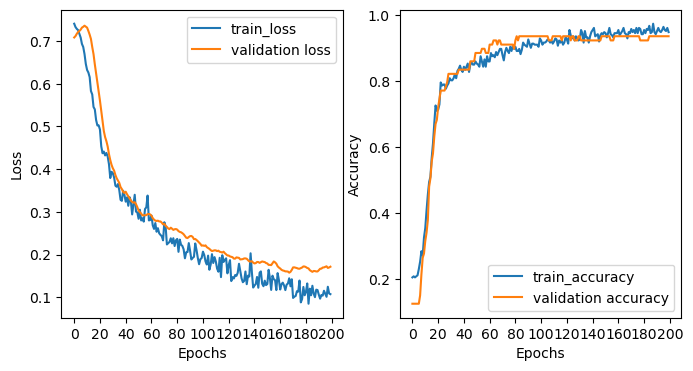

4/4 [==============================] - 0s 0s/step


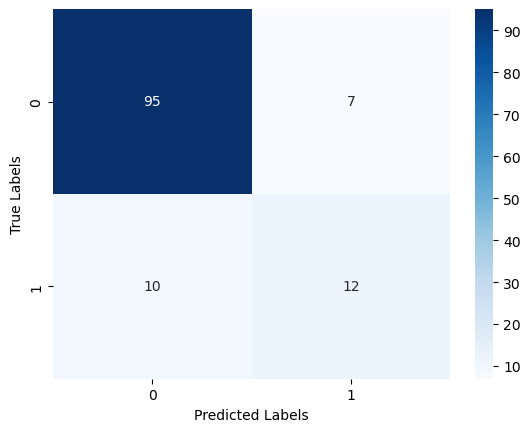

Training...
Accuracy: 0.8870967626571655


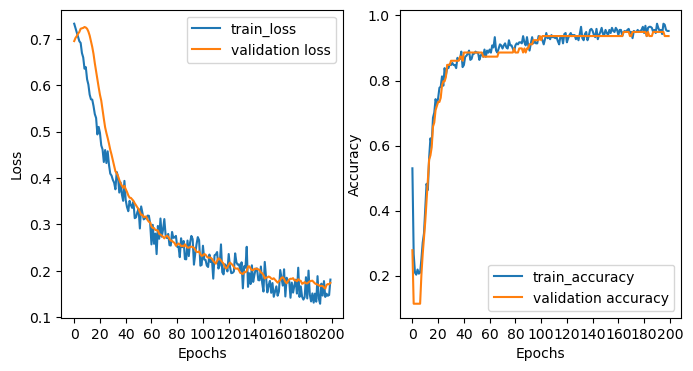

4/4 [==============================] - 0s 1ms/step


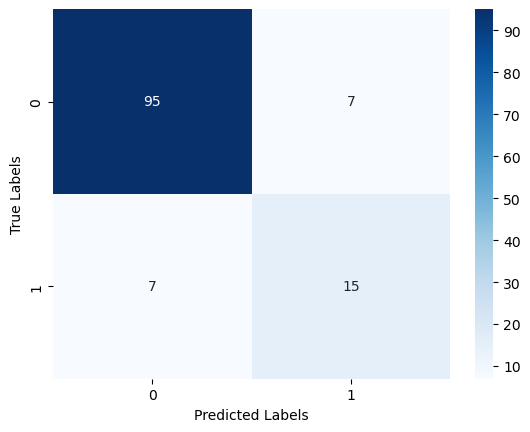

Training...
Accuracy: 0.8790322542190552


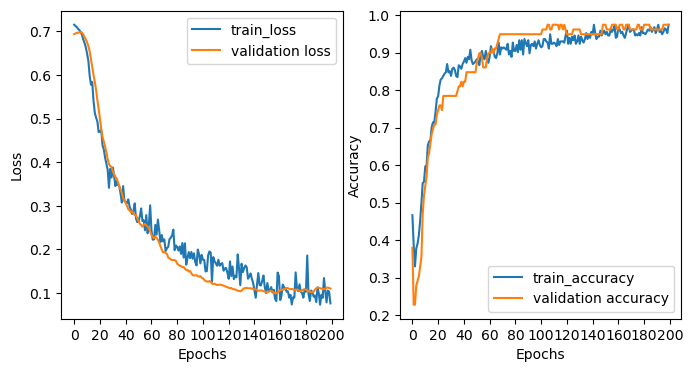

4/4 [==============================] - 0s 701us/step


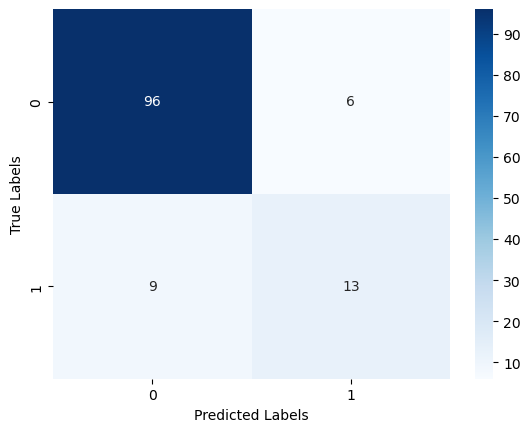

Training...
Accuracy: 0.8870967626571655


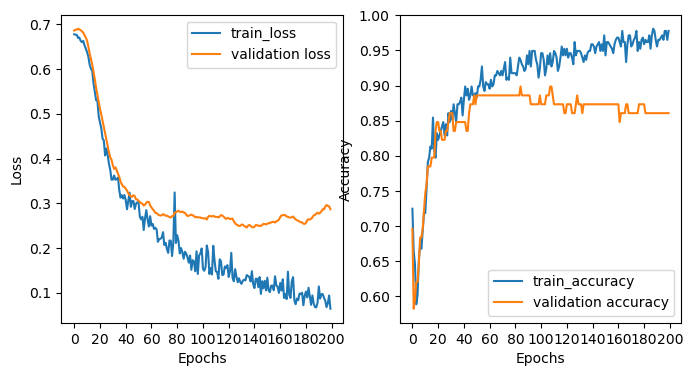

4/4 [==============================] - 0s 667us/step


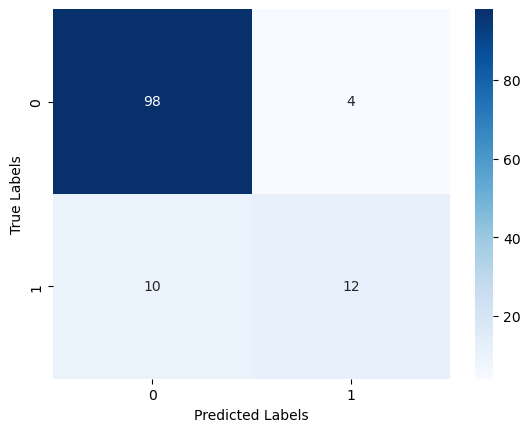

Training...
Accuracy: 0.8629032373428345


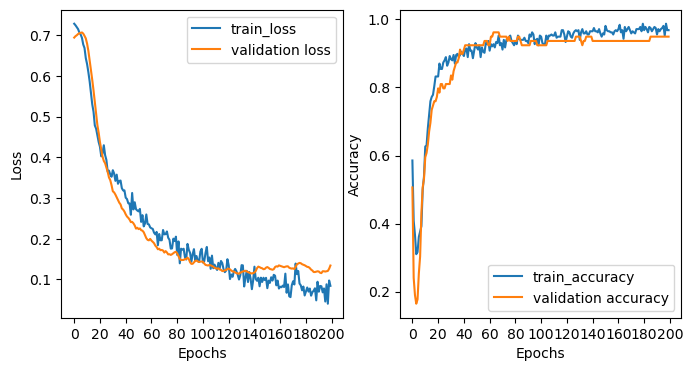

4/4 [==============================] - 0s 1ms/step


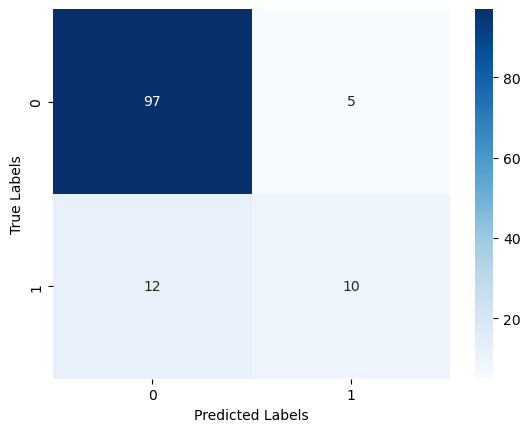

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.875806450843811


In [7]:
# Feedforward Neural Network (FFNN) Model builds upon the logistic regression model 
# by adding hidden layers between the input layer and the output layer.

train_and_evaluate(
    hidden_layer_sizes=[20,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.001,
    dropout_rate=0.2,
    num_epochs=200,
    num_folds=5)

Training...
Accuracy: 0.8629032373428345


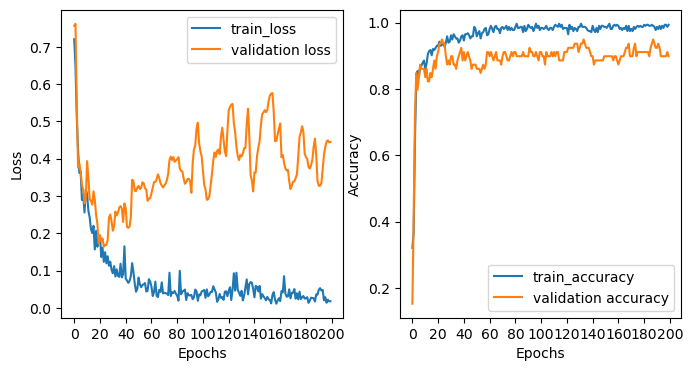

4/4 [==============================] - 0s 689us/step


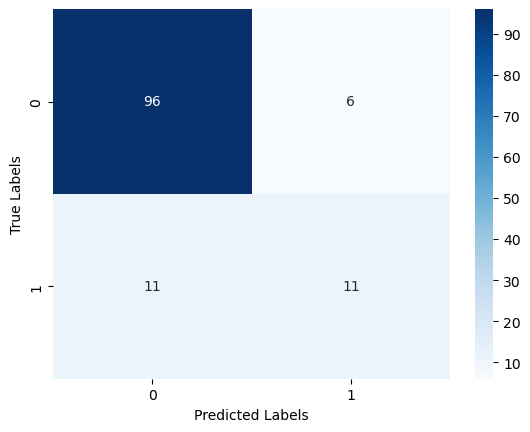

Training...
Accuracy: 0.9032257795333862


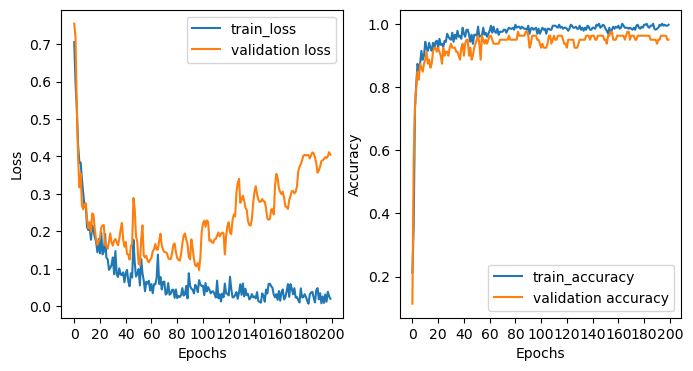

4/4 [==============================] - 0s 666us/step


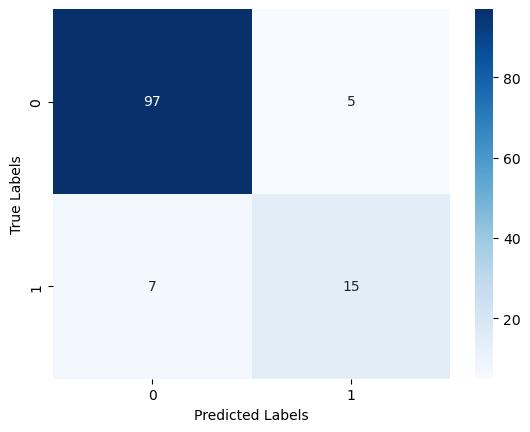

Training...
Accuracy: 0.9112903475761414


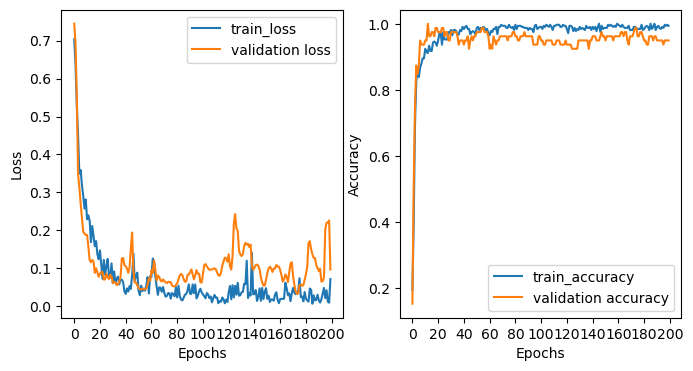

4/4 [==============================] - 0s 690us/step


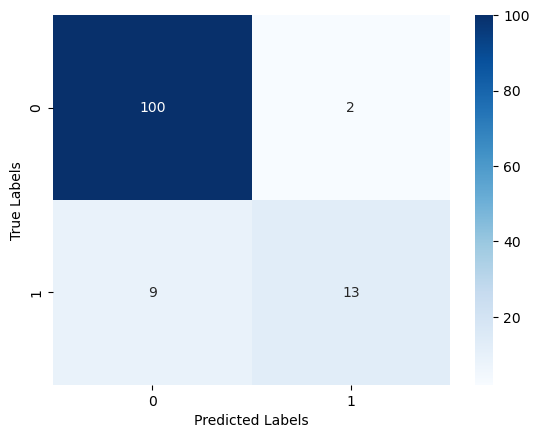

Training...
Accuracy: 0.8951612710952759


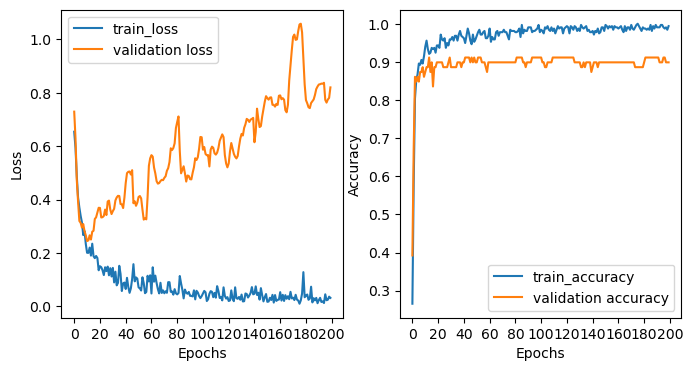

4/4 [==============================] - 0s 344us/step


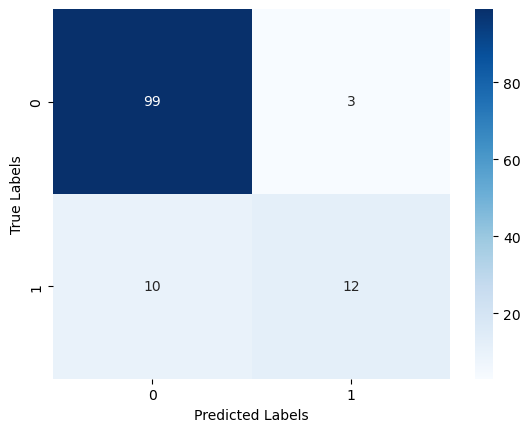

Training...
Accuracy: 0.9032257795333862


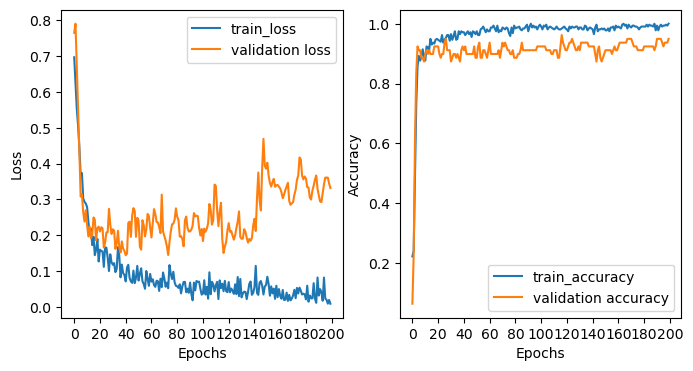

4/4 [==============================] - 0s 0s/step


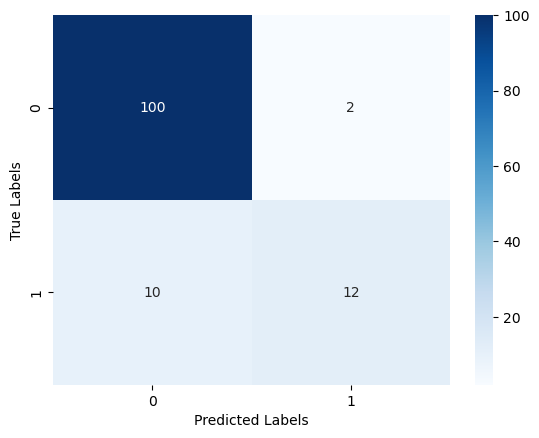

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8951612830162048


In [8]:
# The learning curves for the above model did not appear to plateau. Therefore, 
# should increase the amount of learning by either increasing the learning rate or
# increasing the number of epochs. In this case, will increase the learning rate to
# 0.01 from 0.001.

train_and_evaluate(
    hidden_layer_sizes=[20,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    dropout_rate=0.2,
    num_epochs=200,
    num_folds=5)

Training...
Accuracy: 0.8629032373428345


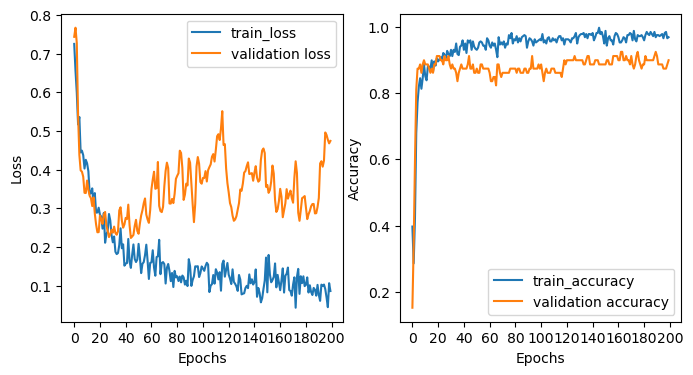

4/4 [==============================] - 0s 1ms/step


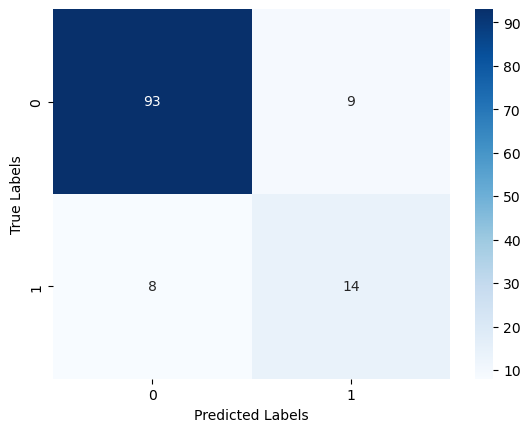

Training...
Accuracy: 0.8709677457809448


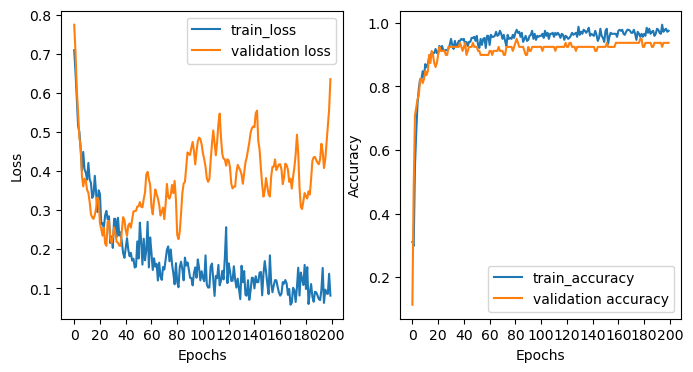

4/4 [==============================] - 0s 1000us/step


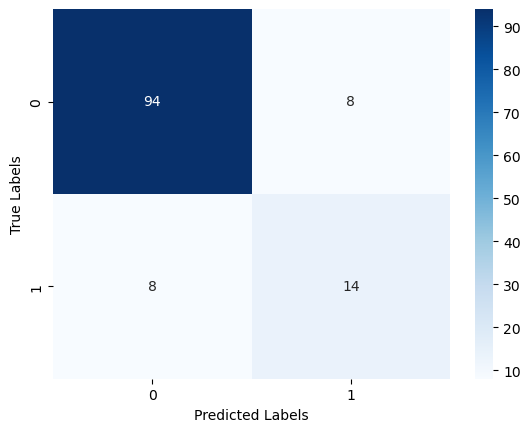

Training...
Accuracy: 0.9032257795333862


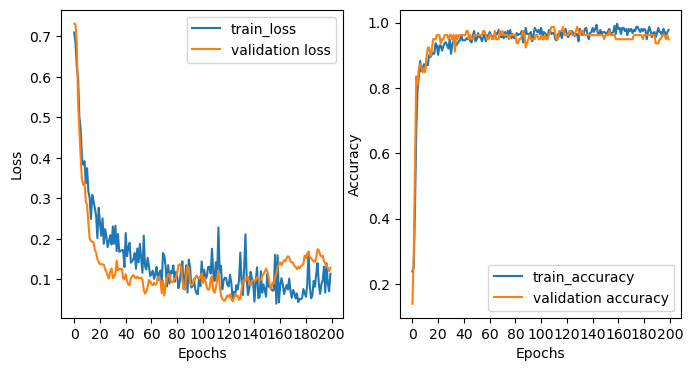

4/4 [==============================] - 0s 1ms/step


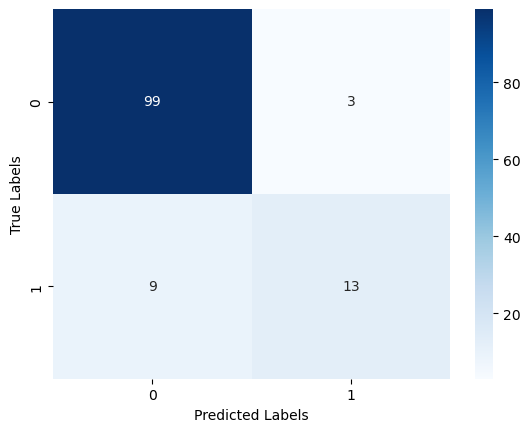

Training...
Accuracy: 0.9112903475761414


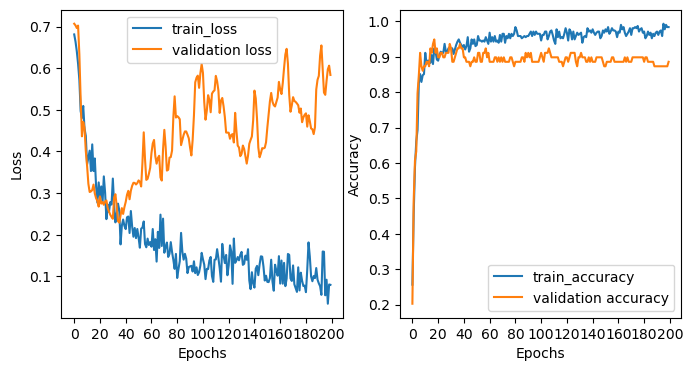

4/4 [==============================] - 0s 0s/step


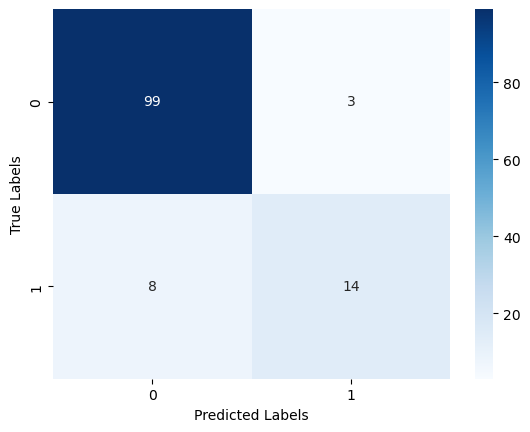

Training...
Accuracy: 0.8790322542190552


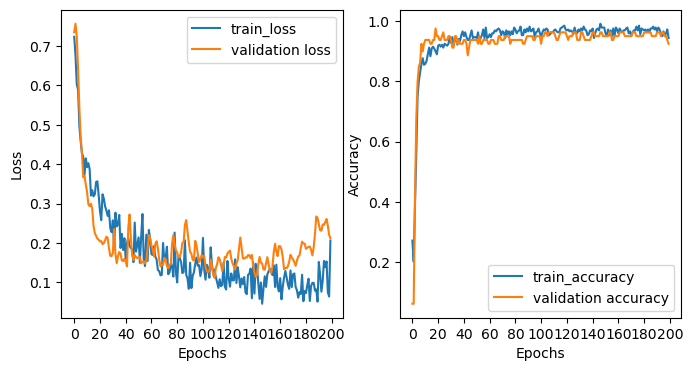

4/4 [==============================] - 0s 1ms/step


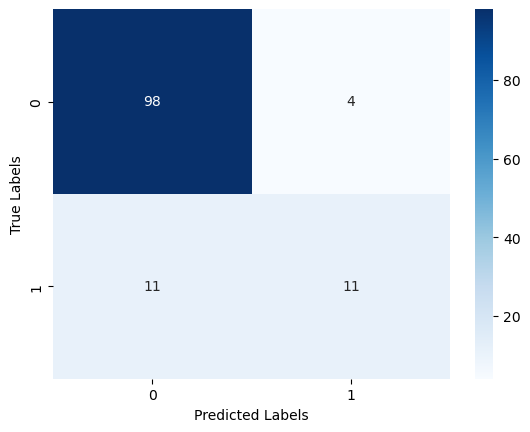

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8854838728904724


In [9]:
# The learning curves for the above model have the validation loss diverging from the training
# loss after about 30 epochs, which is an indication of overfitting. Can address this through
# regularizing the model (increase dropout rate) or decrease model complexity (reduce number
# of hidden layers or the number of nodes per layer).In this case, will increase the dropout rate to
# 0.4 from 0.2.

train_and_evaluate(
    hidden_layer_sizes=[20,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    dropout_rate=0.4,
    num_epochs=200,
    num_folds=5)

Training...
Accuracy: 0.8629032373428345


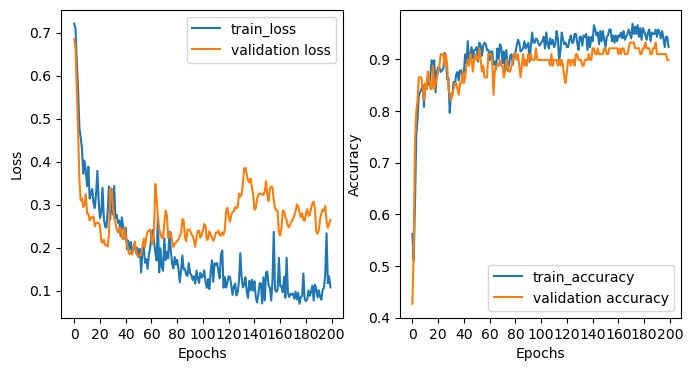

4/4 [==============================] - 0s 1ms/step


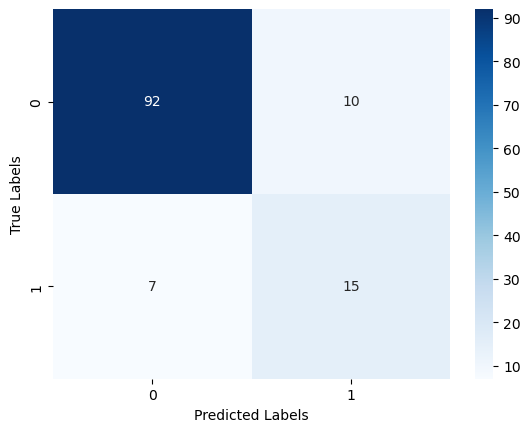

Training...
Accuracy: 0.8790322542190552


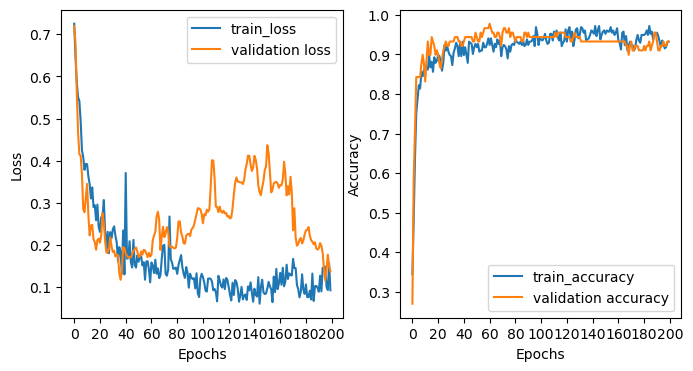

4/4 [==============================] - 0s 1ms/step


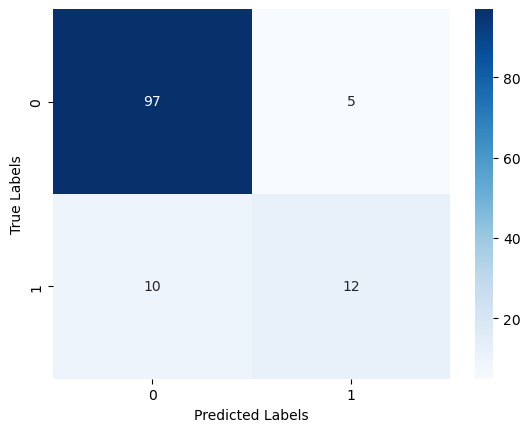

Training...
Accuracy: 0.8629032373428345


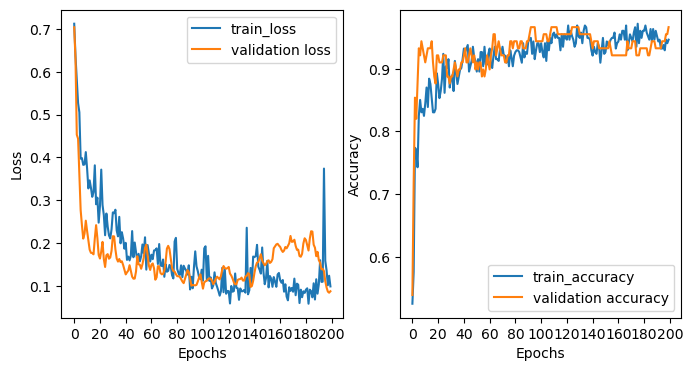

4/4 [==============================] - 0s 1ms/step


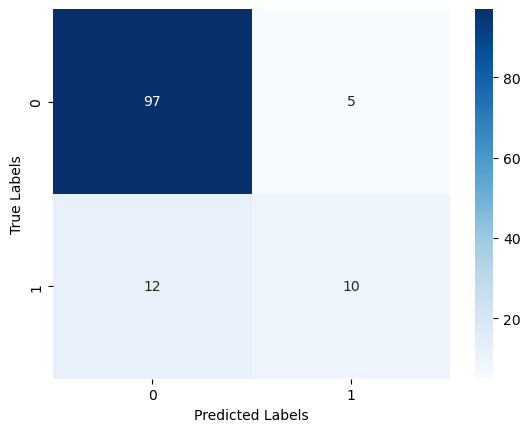

Training...
Accuracy: 0.8709677457809448


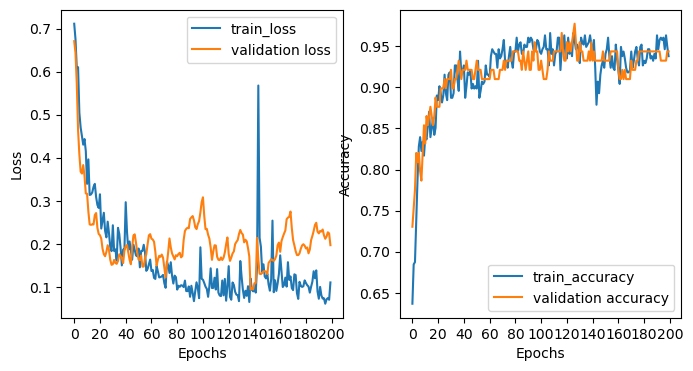

4/4 [==============================] - 0s 0s/step


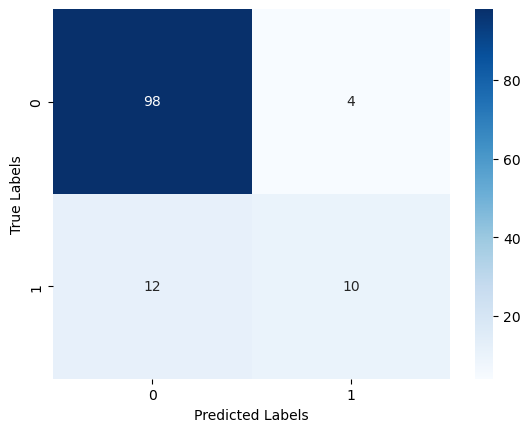

Training...
Accuracy: 0.9032257795333862


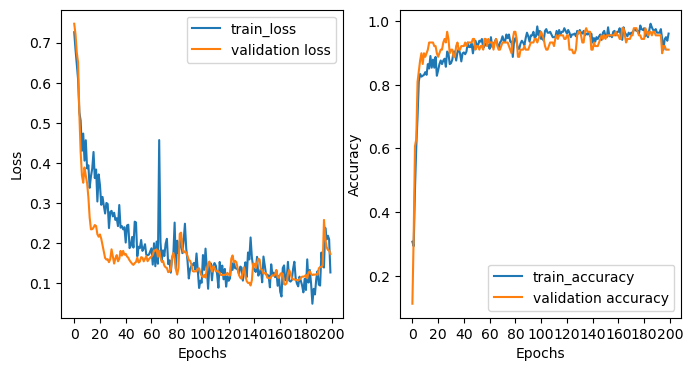

4/4 [==============================] - 0s 1ms/step


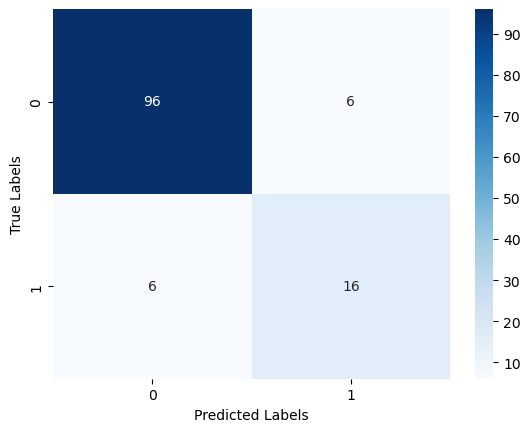

Training...
Accuracy: 0.8709677457809448


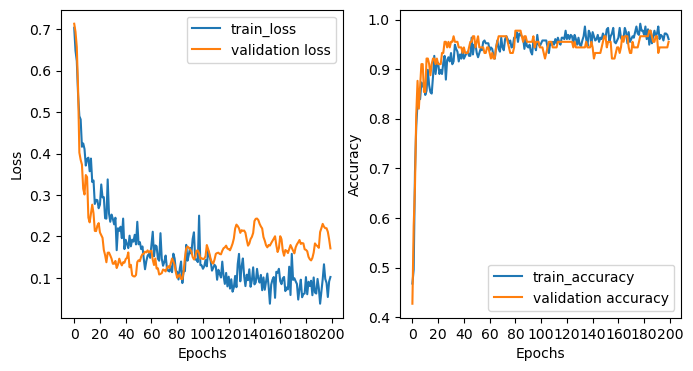

4/4 [==============================] - 0s 0s/step


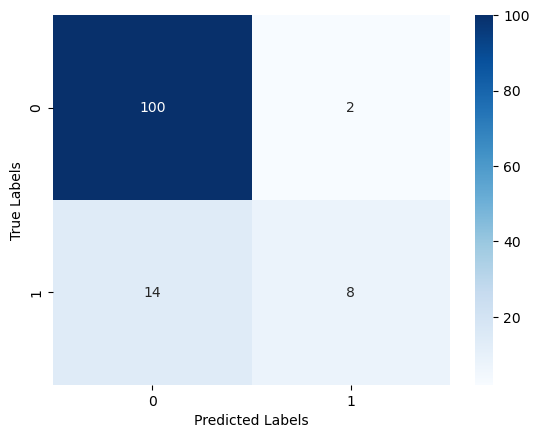

Training...
Accuracy: 0.9032257795333862


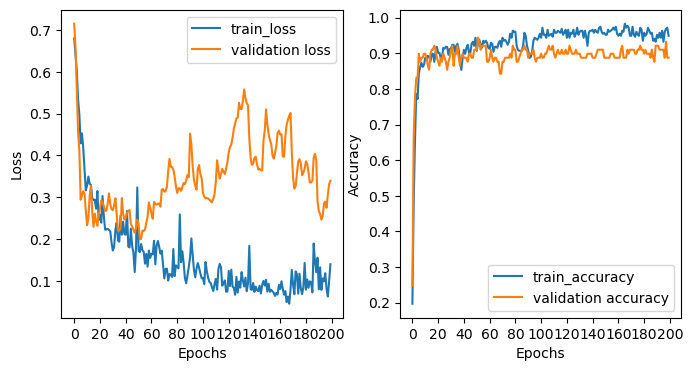

4/4 [==============================] - 0s 1ms/step


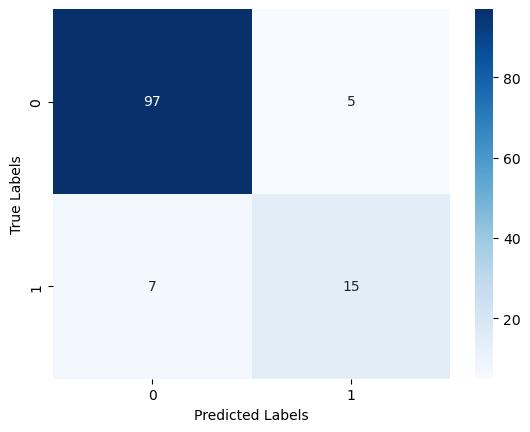

Training...
Accuracy: 0.8790322542190552


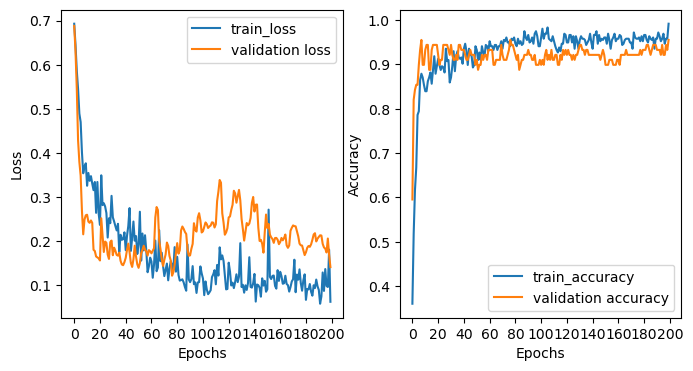

4/4 [==============================] - 0s 700us/step


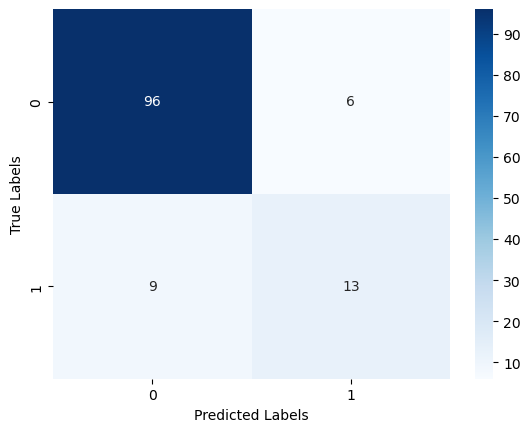

Training...
Accuracy: 0.9032257795333862


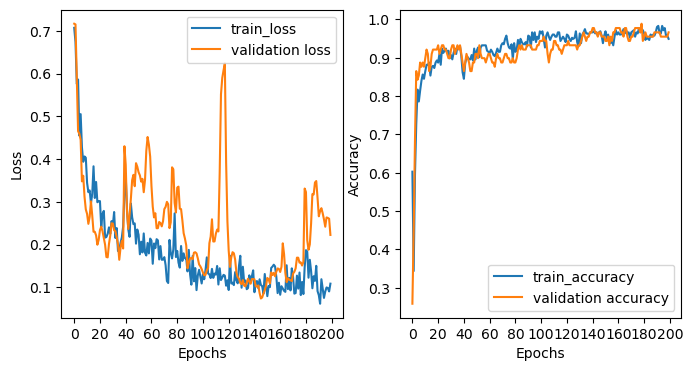

4/4 [==============================] - 0s 1ms/step


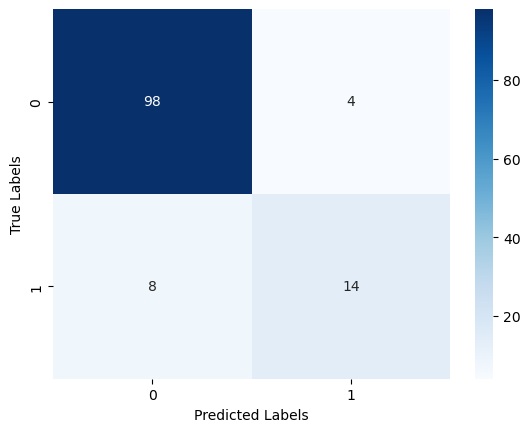

Training...
Accuracy: 0.8709677457809448


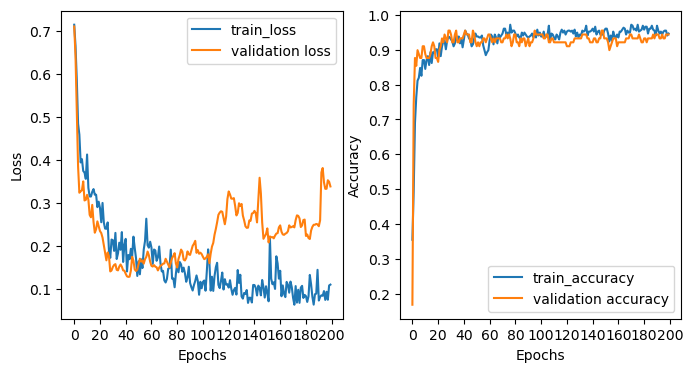

4/4 [==============================] - 0s 1ms/step


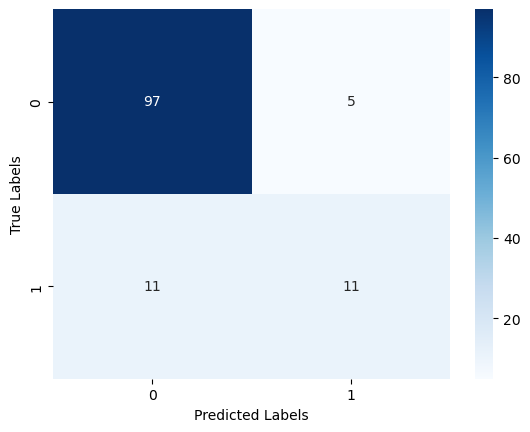

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8806451559066772


In [10]:
# Will attempt to learn more from the training data by increasing the number of k-folds to 10 from 5.

train_and_evaluate(
    hidden_layer_sizes=[20,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    dropout_rate=0.4,
    num_epochs=200,
    num_folds=10)

In [11]:
# The learning curves have training accuracies that generally converge between
# the training curve and the validation curve. The training accureacy curves are slightly 
# higher than the validation accuracy curves, which indicates slight overfitting 
# (a good outcome). There is very little improvement being made with additional 
# hand tuning, so we will stop here.